# Predicting New User Bookings on Airbnb

We seek to predict new user bookings on airbnb using data from 2009 to 2014. 

In [61]:
%matplotlib inline
from  matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from __future__ import division
from scipy.io.arff import loadarff 
from ggplot import *
import scipy as sp 
import numpy as np
import pandas as pd
from sklearn import svm 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import auc, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import Imputer as imp


pd.set_option("display.max_rows", 16) 
sns.set_style("darkgrid")
LARGE_FIGSIZE = (12, 8)


# %cd airbnb-new-bookings
# %ls

In [62]:
#import data
filename = "train_users.csv"
# ?pd.read_table
all_data = pd.read_csv(filename, parse_dates=True, na_values = ["", ".", " ", "NA", "NaN", "-unknown-"])
all_data.drop('id',axis=1, inplace=True)
all_data.head()
# all_data.age.values

date_account_created  timestamp_first_active date_first_booking  gender  \
0           2010-06-28          20090319043255                NaN     NaN   
1           2011-05-25          20090523174809                NaN    MALE   
2           2010-09-28          20090609231247         2010-08-02  FEMALE   
3           2011-12-05          20091031060129         2012-09-08  FEMALE   
4           2010-09-14          20091208061105         2010-02-18     NaN   

    age signup_method  signup_flow language affiliate_channel  \
0   NaN      facebook            0       en            direct   
1  38.0      facebook            0       en               seo   
2  56.0         basic            3       en            direct   
3  42.0      facebook            0       en            direct   
4  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app first_device_type  \
0             direct               untracked        Web       Mac Desktop   
1             google               untracked        Web       Mac Desktop   
2             direct               untracked        Web   Windows Desktop   
3             direct               untracked        Web       Mac Desktop   
4             direct               untracked        Web       Mac Desktop   

  first_browser country_destination  
0        Chrome                 NDF  
1        Chrome                 NDF  
2            IE                  US  
3       Firefox               other  
4        Chrome                  US

## Lets explore the data!

In [63]:
#number of features
print "Looks like we have %s predictors" % all_data.shape[1]
print "And %s rows " % all_data.shape[0]
print
print "The object types in this dataset are: "
for col in all_data:
    print col, all_data[col].dtypes
print 
# all_data.columns.values.tolist()
# all_data.date_first_booking
print "Percentages of Missing Values"
nan_data = (all_data.isnull().sum() / all_data.shape[0]) * 100
nan_data[nan_data > 0]
# all_data.country_destination.isnull().sum()
# print nan_data

Looks like we have 15 predictors
And 213451 rows 

The object types in this dataset are: 
date_account_created object
timestamp_first_active int64
date_first_booking object
gender object
age float64
signup_method object
signup_flow int64
language object
affiliate_channel object
affiliate_provider object
first_affiliate_tracked object
signup_app object
first_device_type object
first_browser object
country_destination object

Percentages of Missing Values


date_first_booking         58.347349
gender                     44.829024
age                        41.222576
first_affiliate_tracked     2.841402
first_browser              12.773892
dtype: float64

## Data Visualizations

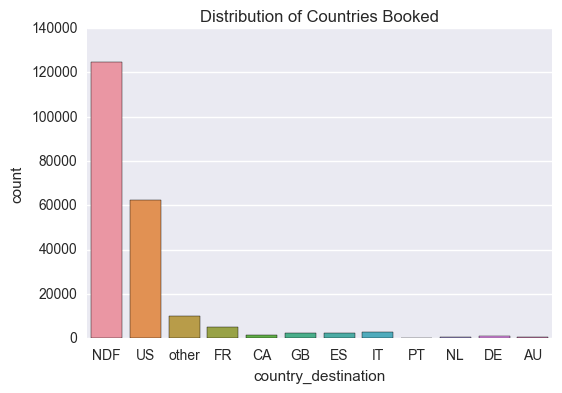

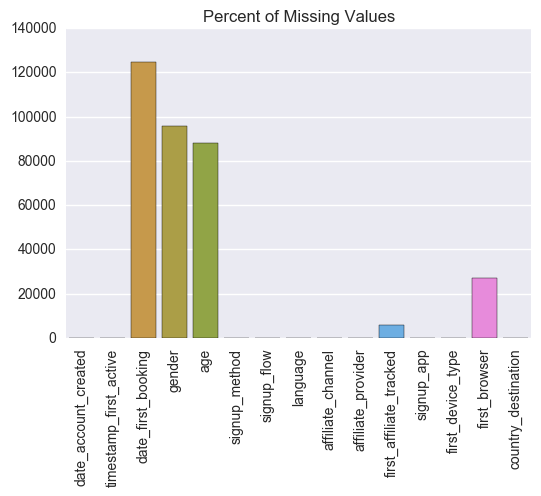

In [64]:
#distribution of countries
country_plot = sns.countplot(x='country_destination', data=all_data)
plt.title("Distribution of Countries Booked")
sns.plt.show()
#sns.barplot(x=all_data.country_destination.value_counts().index, y=all_data.country_destination.value_counts())

#number of NA
plot = sns.barplot(x=all_data.columns.values, y=all_data.isnull().sum())
plot.set_xticklabels(all_data.columns.values,rotation=30)
plt.title("Percent of Missing Values")
plt.xticks(rotation=90)


# total = float(len(all_data)) # one person per row 
# for p in plot.patches:
#     height = p.get_height()
#     per = height/total
#     if per > 0:
#         plot.text(p.get_x(), height+3, '%1.2f'%(per))
sns.plt.show()


## Data Pre-Processing

In [65]:
def remove_outliers(df, column, min_val, max_val):
    col_values = df[column].values
    df[column] = np.where(np.logical_or(col_values<=min_val, col_values>=max_val), np.NaN, col_values)
    return df


In [66]:
print("Fixing timestamps...")
all_data['date_account_created'] = pd.to_datetime(all_data['date_account_created'], format='%Y-%m-%d')
all_data['timestamp_first_active'] = pd.to_datetime(all_data['timestamp_first_active'], format='%Y%m%d%H%M%S')
all_data['date_account_created'].fillna(all_data.timestamp_first_active, inplace=True)

all_data.head()

Fixing timestamps...


date_account_created timestamp_first_active date_first_booking  gender  \
0           2010-06-28    2009-03-19 04:32:55                NaN     NaN   
1           2011-05-25    2009-05-23 17:48:09                NaN    MALE   
2           2010-09-28    2009-06-09 23:12:47         2010-08-02  FEMALE   
3           2011-12-05    2009-10-31 06:01:29         2012-09-08  FEMALE   
4           2010-09-14    2009-12-08 06:11:05         2010-02-18     NaN   

    age signup_method  signup_flow language affiliate_channel  \
0   NaN      facebook            0       en            direct   
1  38.0      facebook            0       en               seo   
2  56.0         basic            3       en            direct   
3  42.0      facebook            0       en            direct   
4  41.0         basic            0       en            direct   

  affiliate_provider first_affiliate_tracked signup_app first_device_type  \
0             direct               untracked        Web       Mac Desktop   
1             google               untracked        Web       Mac Desktop   
2             direct               untracked        Web   Windows Desktop   
3             direct               untracked        Web       Mac Desktop   
4             direct               untracked        Web       Mac Desktop   

  first_browser country_destination  
0        Chrome                 NDF  
1        Chrome                 NDF  
2            IE                  US  
3       Firefox               other  
4        Chrome                  US

Fixing age column...


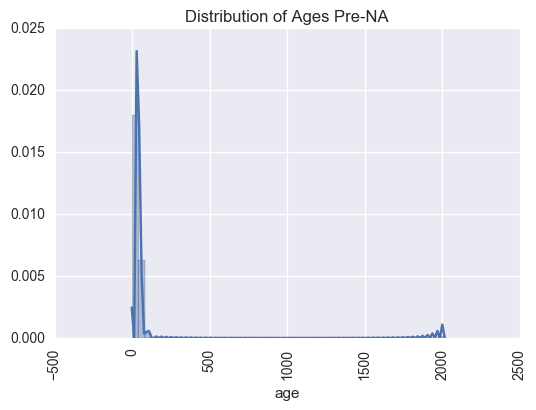

Any NA values in age? True
Imputing missing data with mean age of  36.0
Any NA values in age? False


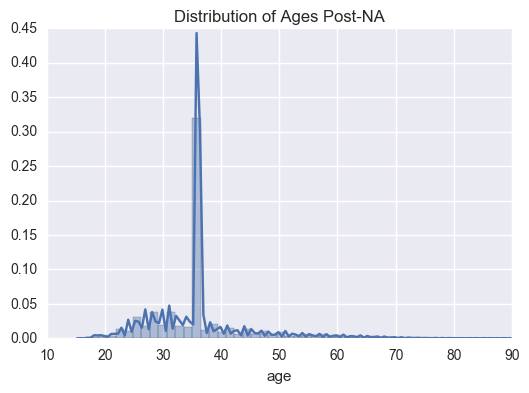

In [67]:
#observe age NA
print ("Fixing age column...")

pre_age_plot = sns.distplot(all_data.age.dropna(), bins =50 )
plt.title("Distribution of Ages Pre-NA")
plt.xticks(rotation=90)
sns.plt.show()

all_data = remove_outliers(df=all_data, column='age', min_val=15, max_val=90)
print "Any NA values in age?", all_data['age'].isnull().values.any()
mean_age = round(np.mean(all_data['age'].loc[all_data['age'].notnull()]))
print "Imputing missing data with mean age of ", mean_age
all_data['age'].fillna(mean_age, inplace=True)
all_data['age']= all_data['age'].astype(int)


print "Any NA values in age?", all_data['age'].isnull().values.any()
post_age_plot =sns.distplot(all_data.age, bins =50 )
plt.title("Distribution of Ages Post-NA")
sns.plt.show()


# all_data.loc[all_data.age > 90, 'age'] = np.nan
# all_data.loc[all_data.age < 19, 'age'] = np.nan
# post_age_plot =sns.distplot(all_data.age.dropna(), bins =50 )
# plt.title("Distribution of Ages Post-NA")
# # post_age_plot.xaxis.set_major_formatter(FormatStrFormatter('%0.0f'))
# plt.xticks(rotation=90)
# sns.plt.show()



In [68]:
def fix_first_browser(df):
    list = ['Chrome', 'Safari', 'Firefox', 'IE', 'Mobile Safari', 'Chrome Mobile', 'Android Browser']
    for i, row in df.iterrows():
        if row.first_browser not in list:
           df.set_value(i,'first_browser', 'other')
    return df

Fixing date_first_booking...
Fixing first_affiliate_tracked...
Any NA values? False


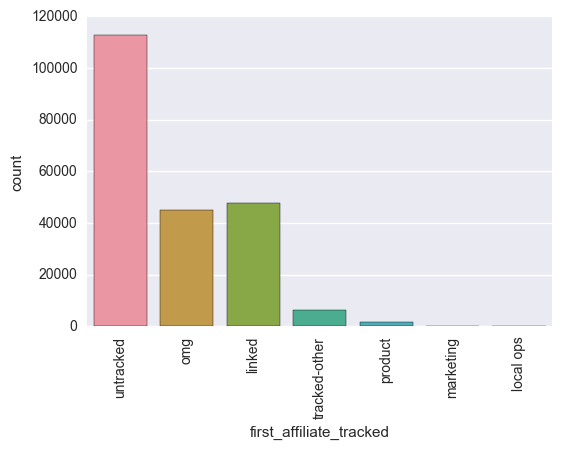

Fixing first_browser...


In [69]:
print("Fixing date_first_booking...")
all_data.drop('date_first_booking', axis=1, inplace=True)

print("Fixing first_affiliate_tracked...")
all_data['first_affiliate_tracked'].fillna(method = 'ffill', inplace = True)
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()
affiliate_plot =sns.countplot(all_data['first_affiliate_tracked'])
plt.xticks(rotation=90)
sns.plt.show()
# print "Current NA count:", all_data['first_affiliate_tracked'].isnull().sum()
# all_data = all_data[all_data.first_affiliate_tracked.notnull()]
# print "New NA count:", all_data['first_affiliate_tracked'].isnull().sum()

print ("Fixing first_browser...")
all_data = fix_first_browser(all_data)

# print all_data.head()
# all_data['first_browser'].fillna(method = 'ffill', inplace = True)


In [70]:
print all_data['first_browser'].value_counts().index.tolist()


['Chrome', 'Safari', 'Firefox', 'other', 'IE', 'Mobile Safari', 'Chrome Mobile', 'Android Browser']


In [71]:
#fix datatypes
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

print("Converting objects to categories...")
for categorical_feature in categorical_features:
   all_data[categorical_feature] = all_data[categorical_feature].astype('category')


Converting objects to categories...


Adding new date fields...
Any NA values? False


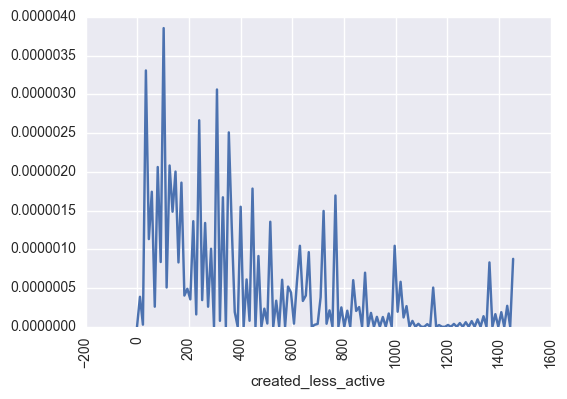

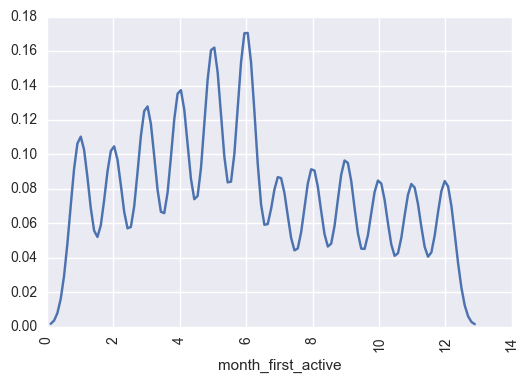

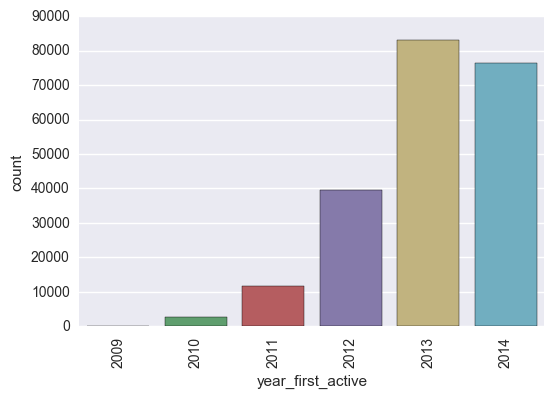

In [72]:
#extracting date values 
# Add new date related fields
print("Adding new date fields...")
all_data['day_account_created'] = all_data['date_account_created'].dt.weekday
all_data['month_account_created'] = all_data['date_account_created'].dt.month
all_data['quarter_account_created'] = all_data['date_account_created'].dt.quarter
all_data['year_account_created'] = all_data['date_account_created'].dt.year
all_data['hour_first_active'] = all_data['timestamp_first_active'].dt.hour
all_data['day_first_active'] = all_data['timestamp_first_active'].dt.weekday
all_data['month_first_active'] = all_data['timestamp_first_active'].dt.month
all_data['quarter_first_active'] = all_data['timestamp_first_active'].dt.quarter
all_data['year_first_active'] = all_data['timestamp_first_active'].dt.year
all_data['created_less_active'] = (all_data['date_account_created'] - all_data['timestamp_first_active']).dt.days

# Drop unnecessary columns
columns_to_drop = ['date_account_created', 'timestamp_first_active']
for column in columns_to_drop:
    if column in all_data.columns:
        all_data.drop(column, axis=1, inplace=True)

# all_data.head()
print "Any NA values?", all_data['first_affiliate_tracked'].isnull().values.any()

created_less_plot =sns.distplot(all_data['created_less_active'], hist = False)
plt.xticks(rotation=90)
sns.plt.show()

created_less_plot =sns.distplot(all_data['month_first_active'], hist = False)
plt.xticks(rotation=90)
sns.plt.show()

created_less_plot =sns.countplot(all_data['year_first_active'])
plt.xticks(rotation=90)
sns.plt.show()

# sns.regplot(all_data['created_less_active'],all_data['year_first_active'])
# plt.xticks(rotation=90)
# sns.plt.show()

In [73]:
# all_data['created_less_active'].value_counts().index.tolist()

Fixing gender...


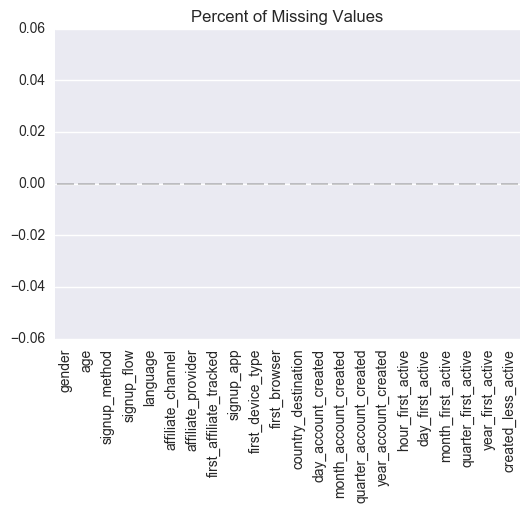

In [75]:
print("Fixing gender...")
pick_gender = ['FEMALE','MALE']
all_data['gender'].fillna(np.random.choice(pick_gender), inplace = True)

#updated missing values
plot = sns.barplot(x=all_data.columns.values, y=all_data.isnull().sum())
plot.set_xticklabels(all_data.columns.values,rotation=90)
plt.title("Percent of Missing Values")
sns.plt.show()

## Dummy Encode Categoricals

In [76]:
print "Generating dummy variables for categoricals..."
features = [
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]
dummies = pd.get_dummies(all_data[features])

for feature in all_data[features]:
    all_data.drop(feature,axis = 1, inplace = True)

frames = [all_data, dummies]
data_with_dummies = pd.concat(frames, axis = 1)

# data_with_dummies.columns.tolist()
# print data_with_dummies['created_less_active']

Generating dummy variables for categoricals...


['age',
 'signup_flow',
 'country_destination',
 'day_account_created',
 'month_account_created',
 'quarter_account_created',
 'year_account_created',
 'hour_first_active',
 'day_first_active',
 'month_first_active',
 'quarter_first_active',
 'year_first_active',
 'created_less_active',
 'affiliate_channel_api',
 'affiliate_channel_content',
 'affiliate_channel_direct',
 'affiliate_channel_other',
 'affiliate_channel_remarketing',
 'affiliate_channel_sem-brand',
 'affiliate_channel_sem-non-brand',
 'affiliate_channel_seo',
 'affiliate_provider_baidu',
 'affiliate_provider_bing',
 'affiliate_provider_craigslist',
 'affiliate_provider_daum',
 'affiliate_provider_direct',
 'affiliate_provider_email-marketing',
 'affiliate_provider_facebook',
 'affiliate_provider_facebook-open-graph',
 'affiliate_provider_google',
 'affiliate_provider_gsp',
 'affiliate_provider_meetup',
 'affiliate_provider_naver',
 'affiliate_provider_other',
 'affiliate_provider_padmapper',
 'affiliate_provider_vast',
 '

## Split the data!

In [30]:
n_train = int((0.7*len(all_data)))
print "training size should be, ", n_train

#randomize sampling
np.random.seed(0) 
data_with_dummies = data_with_dummies.reindex(np.random.permutation(data_with_dummies.index))

#split into training and testing

x_train= data_with_dummies.iloc[:n_train, data_with_dummies.columns != 'country_destination'] #get everything but country destination
print "X train size is", x_train.shape
x_train_target = data_with_dummies.iloc[:n_train, data_with_dummies.columns =='country_destination']
print "X train_target size is", x_train_target.shape


print "\nX test should be", data_with_dummies.shape[0]-n_train

x_test= data_with_dummies.iloc[n_train+1:, data_with_dummies.columns != 'country_destination'] #get everything but country destination
print "X test size is", x_test.shape
x_test_target = data_with_dummies.iloc[n_train+1:, data_with_dummies.columns =='country_destination']
print "X test_target size is", x_test_target.shape



training size should be,  149415
X train size is (149415, 140)
X train_target size is (149415, 1)

X test should be 64036
X test size is (64035, 140)
X test_target size is (64035, 1)


In [39]:
?RandomForestClassifier

## Random Forest Attempt 1
### 10 trees. With One-hot encoding.

In [36]:
rf = RandomForestClassifier(n_estimators=10, verbose=1)
rf.fit(x_train, x_train_target)

#confusion matrix
x_test_predict_proba = rf.predict_proba(x_test)[:,1]
x_test_predict = rf.predict(x_test)
cm = confusion_matrix(x_test_target, x_test_predict)
print "Confusion Matrix: \n",cm

#mean accuracy
acc = rf.score(x_test, x_test_target)
print "Mean accuracy: ",acc


/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


Confusion Matrix: 
[[    0     0     0     0     7     0     2    87     0     0    57     1]
 [    0     2     2     4    11     5     5   266     1     1   164     9]
 [    0     1     1     1     2     0     0   183     1     0    99     3]
 [    1     4     1     4     6     4     8   411     1     0   222    16]
 [    4     5     4     6    20     7     7   891     3     0   493    25]
 [    1     1     1     2    11     9     5   435     1     0   255    11]
 [    0     2     2     5     9     3     5   545     3     0   280     9]
 [   20    66    48    97   276   122   131 29509    30     5  6693   470]
 [    0     0     0     0     2     1     0   124     0     0    90     5]
 [    0     0     0     0     0     2     0    46     0     0    17     1]
 [   16    56    42    92   186    95    99 11317    22     3  6425   327]
 [    1     8     5    18    22    13    22  1814     6     0   967    71]]
Mean accuracy:  0.562910908097


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


## Random Forest Attempt 2
### 30 trees. With One-hot encoding.

In [38]:
rf = RandomForestClassifier(n_estimators=30, verbose=1)
rf.fit(x_train, x_train_target)

#confusion matrix
x_test_predict_proba = rf.predict_proba(x_test)[:,1]
x_test_predict = rf.predict(x_test)
cm = confusion_matrix(x_test_target, x_test_predict)
print "Confusion Matrix: \n",cm

#mean accuracy
acc = rf.score(x_test, x_test_target)
print "Mean accuracy: ",acc


/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   12.1s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished


Confusion Matrix: 
[[    0     0     0     0     5     0     2    86     0     0    59     2]
 [    0     0     1     2     4     3     5   265     1     0   183     6]
 [    1     2     1     1     0     3     1   176     0     0   105     1]
 [    1     2     0     3     6     4     6   395     0     1   246    14]
 [    1     1     4     2    10     5     6   884     2     0   523    27]
 [    0     1     1     1     8     4     2   440     0     0   264    11]
 [    0     2     1     4     5     3     4   533     2     0   299    10]
 [   12    58    31    67   194   100   100 29662    26     6  6739   472]
 [    0     1     0     0     3     0     0   129     0     0    85     4]
 [    0     0     1     0     0     1     0    40     0     0    23     1]
 [   14    47    14    57   128    65    57 11082    13     1  6947   255]
 [    1     3     4     8    24     7    15  1802     8     0  1016    59]]
Mean accuracy:  0.572967908175


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.1s finished


## Random Forest Attempt 3
### 30 trees. With One-hot encoding.

In [44]:
rf = RandomForestClassifier(n_estimators=30, verbose=1)
rf.fit(x_train, x_train_target)

#confusion matrix
print rf.predict_proba(x_test).tolist()
# print rf.predict_proba(x_test).shape
# x_test_predict_proba = rf.predict_proba(x_test)[:,1]
# x_test_predict = rf.predict(x_test)
# cm = confusion_matrix(x_test_target, x_test_predict)
# print "Confusion Matrix: \n",cm

# #mean accuracy
# acc = rf.score(x_test, x_test_target)
# print "Mean accuracy: ",acc


/Users/eightiesfanjan/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   12.2s finished
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished


[[0.0, 0.03333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23333333333333334, 0.0, 0.0, 0.6666666666666666, 0.06666666666666667], [0.0, 0.13333333333333333, 0.0, 0.0, 0.0, 0.0, 0.23333333333333334, 0.6166666666666667, 0.0, 0.0, 0.016666666666666666, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8666666666666667, 0.0, 0.0, 0.13333333333333333, 0.0], [0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.43333333333333335, 0.0, 0.0, 0.3333333333333333, 0.03333333333333333], [0.03333333333333333, 0.0, 0.06666666666666667, 0.0, 0.0, 0.03333333333333333, 0.0, 0.36666666666666664, 0.0, 0.0, 0.43333333333333335, 0.06666666666666667], [0.0, 0.03333333333333333, 0.0, 0.0, 0.06666666666666667, 0.03333333333333333, 0.0, 0.3333333333333333, 0.0, 0.0, 0.4666666666666667, 0.06666666666666667], [0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.03333333333333333, 0.4, 0.0, 0.0, 0.4666666666666667, 0.03333333333333333], [0.0, 0.03333333333333333, 0.0, 0.0, 0.2, 0.0, 0.0, 0.26666666666666666, 0.0, 0.0, 0.5, 0.0], [0.0, 0.0, 0.

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.4s finished
